# ANN Model2

In [1]:
import numpy as np
from keras.utils import to_categorical

In [2]:
x_train = np.load('x_train_ann.npy',allow_pickle=True)
x_test = np.load('x_test_ann.npy',allow_pickle=True)
y_train = np.load('y_train_ann.npy',allow_pickle=True)
y_test = np.load('y_test_ann.npy',allow_pickle=True)

Using TensorFlow backend.


In [4]:
#Converting to One_Hot_Vector
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
print(y_train.shape)
print(y_test.shape)

(17835, 15)
(4459, 15)


In [5]:
print(x_train.shape , y_train.shape , x_test.shape , y_test.shape)

(17835, 19200) (17835, 15) (4459, 19200) (4459, 15)


In [33]:
#Extracting the actual class of the leaf
actual_output = []
for y in y_test:
    actual_output.append(y.argmax())

In [34]:
actual_output = np.array(actual_output) #Conversion to a numpy array

In [64]:
class Artificial_Neural_Network:
    
    def __init__(self, X, y,val_x,val_y,classes):
        
        # X,y are for training and testX,testy are for testing
        self.X = X
        self.y = y
        self.testX = val_x
        self.testy = val_y
        
        # Neurons in the 3 hidden layers
        self.H1_size = 1024
        self.H2_size = 512
        self.H3_size = 256
        
        self.OUTPUT_SIZE = classes     # 15
        self.INPUT_SIZE = X.shape[1]   # 17835
        self.losses = []
        
        # Initialize weights (2d matrices)
        self.W1 = np.random.randn(self.INPUT_SIZE, self.H1_size)
        self.W2 = np.random.randn(self.H1_size, self.H2_size)
        self.W3 = np.random.randn(self.H2_size, self.H3_size)
        self.W4 = np.random.randn(self.H3_size, self.OUTPUT_SIZE)
        
        # Initialize biases (2d matrices)
        self.b1 = np.random.random((1, self.H1_size))
        self.b2 = np.random.random((1, self.H2_size))
        self.b3 = np.random.random((1, self.H3_size))
        self.b4 = np.random.random((1, self.OUTPUT_SIZE))
    
    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))
    
    # Derivative of sigmoid function
    def sigmoid_prime(self, z):
        s = self.sigmoid(z)
        return s * (1 - s)
    
    def softmax(self, z):
        return np.exp(z) / np.sum(np.exp(z), axis=1, keepdims=True)
    
    def forward(self, x):
        
        # 1st layer output
        Z1   = x.dot(self.W1) + self.b1
        A1   = self.sigmoid(Z1)
        
        # 2nd layer output
        Z2   = A1.dot(self.W2) + self.b2
        A2   = self.sigmoid(Z2)
        
        # 3rd layer output
        Z3   = A2.dot(self.W3) + self.b3
        A3   = self.sigmoid(Z3)
        
        # 4th layer output
        Z4   = A3.dot(self.W4) + self.b4
        yhat = self.softmax(Z4)
        
        # Values after activation function of each layer
        self.activations = [A1, A2, A3, yhat]
        
        return yhat
    
    def backprop(self, x, y, yhat, learning_rate=0.01):
        
        A1, A2, A3, yhat = self.activations
        
        # Compute Gradients
        del4 = yhat - y
        dl_dw4  = A3.T.dot(del4)
        dl_db4  = del4.sum(axis=0, keepdims=True)
        
        del3 = del4.dot(self.W4.T) * (A3 * (1 - A3))
        dl_dw3  = A2.T.dot(del3)
        dl_db3  = del3.sum(axis=0, keepdims=True)
        
        del2 = del3.dot(self.W3.T) * (A2 * (1 - A2))
        dl_dw2  = A1.T.dot(del2)
        dl_db2  = del2.sum(axis=0, keepdims=True)
    
        del1 = del2.dot(self.W2.T) * (A1 * (1 - A1))
        dl_dw1  = x.T.dot(del1)
        dl_db1  = del1.sum(axis=0, keepdims=True)

        # Update Weights
        self.W4 -= dl_dw4 * learning_rate
        self.b4 -= dl_db4 * learning_rate
        
        self.W3 -= dl_dw3 * learning_rate
        self.b3 -= dl_db3 * learning_rate
        
        self.W2 -= dl_dw2 * learning_rate
        self.b2 -= dl_db2 * learning_rate
        
        self.W1 -= dl_dw1 * learning_rate
        self.b1 -= dl_db1 * learning_rate
        
        
    # Prediction of 1 image 
    def get_predictions(self, testdata):
        yhat = self.forward(testdata)
        preds = np.argmax(yhat, axis=1)
        return preds
    
    # Predictions of all images
    def get_all_predictions(self,testdata):
        preds = []
        for x in testdata:
            preds.append(self.get_predictions(x)[0])
        return np.array(preds)
    
    def train(self, learning_rate=0.001, epochs=10, batchsize=128):
        
        # Reversing the one hot vectors of Actual Output (Actual class)
        y_train_actual = self.reversal_of_one_hot(self.y)
        y_test_actual = self.reversal_of_one_hot(self.testy)
        
        # Loop for each epoch
        for e in range(epochs):
            size = 0
            
            # Applying forward and backward propagations batch wise with a batch size of 128
            while size + batchsize < self.X.shape[0]:
                xbatch = self.X[size : size + batchsize]
                ybatch = self.y[size : size + batchsize]
                size += batchsize

                yhat_batch = self.forward(xbatch)
                self.backprop(xbatch, ybatch, yhat_batch, learning_rate)
            
            yhat = self.forward(self.X)
            self.losses.append(self.compute_loss(self.y, yhat))
            
            # Training Accuracy
            train_preds = self.get_all_predictions(self.X)            
            acc = self.accuracy(train_preds , y_train_actual)
            
            # Testing Accuracy
            val_yhat = self.forward(self.testX)
            val_loss = self.compute_loss(self.testy , val_yhat)
            test_preds = self.get_all_predictions(self.testX)
            val_acc = self.accuracy(test_preds , y_test_actual)
            
            # Printing details of each epoch
            print("Epoch [{}/{}]: loss : {}   acc : {}   val_loss : {}  val_acc : {}".format(e,epochs, self.losses[-1] , acc , val_loss , val_acc))

    
    def reversal_of_one_hot(self, y_data):
        actual_output = []
        for y in y_data:
            actual_output.append(y.argmax())
        return np.array(actual_output)
    
    def accuracy(self, preds, true_labels):
        return (preds == true_labels).sum()/preds.shape[0]
    
    def compute_loss(self, y, yhat):
        # L = -E[y log(yhat)]
        return -np.sum(y * np.log(yhat))
    

    

In [65]:
ann = Artificial_Neural_Network(x_train,y_train,x_test,y_test,15)

In [66]:
ann.INPUT_SIZE, ann.H1_size, ann.H2_size, ann.H3_size, ann.OUTPUT_SIZE

(19200, 1024, 512, 256, 15)

In [67]:
print("First Loss: ", ann.compute_loss(ann.y, ann.forward(ann.X)))

First Loss:  350142.57577084674


In [68]:
ann.train(learning_rate=0.001, epochs=40,batch_size=128)

Epoch [0/40]: loss : 46474.8615423675   acc : 0.17045135968601066   val_loss : 11930.754961239518  val_acc : 0.1509307019511101
Epoch [1/40]: loss : 44994.6575096995   acc : 0.2015699467339501   val_loss : 11617.886247018021  val_acc : 0.18008522090154744
Epoch [2/40]: loss : 43905.27972592695   acc : 0.21979254275301374   val_loss : 11393.4428705644  val_acc : 0.19937205651491366
Epoch [3/40]: loss : 42954.75198295132   acc : 0.23050182225960192   val_loss : 11178.524241292314  val_acc : 0.21013680197353668
Epoch [4/40]: loss : 42039.30260207653   acc : 0.23739837398373984   val_loss : 10980.9671983858  val_acc : 0.2141735815205203
Epoch [5/40]: loss : 41277.844396189765   acc : 0.25242500700869075   val_loss : 10856.944536169087  val_acc : 0.22202287508409957
Epoch [6/40]: loss : 40315.47684884919   acc : 0.2638631903560415   val_loss : 10571.549127262784  val_acc : 0.2336846826642745
Epoch [7/40]: loss : 39256.43924613614   acc : 0.28191757779646764   val_loss : 10353.411891633335  

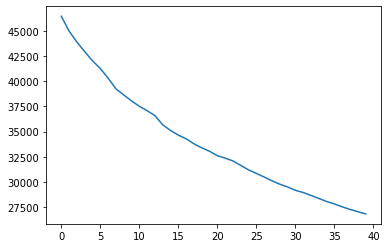

In [69]:
plt.figure()
plt.plot(ann.losses)
plt.show()

In [70]:
preds1 = []
for x in x_test:
    preds1.append(ann.get_predictions(x)[0])

In [71]:
preds1 = np.array(preds1)

In [72]:
ann.accuracy(preds1,actual_output)

0.39268894370935187